Find Players with low potentials but high actual Rating
- Until 21 Rating under 80 and Potential under 80
- between 22 and 32 Rating over 85

In [328]:
import os
import pandas as pd
import numpy as np
import sys
import os
def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

import requests
from bs4 import BeautifulSoup
from src.sport_analytics.crawler.fifa import extract_attributes
from tqdm import tqdm

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [329]:
FIFA = "2022"
sql_query = f"""WITH prime AS (
    SELECT Name, ID, MAX(Overall) AS prime
    FROM fifa
    WHERE fifa > YEAR_PLACEHOLDER
    GROUP BY Name
    HAVING MAX(Overall) > 83  -- Filter prime values greater than 85
),
low_potentials AS (
    SELECT Overall, Potential, Name, ID,age
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
)
SELECT prime.Name AS PrimeName,age, low_potentials.Name AS LowPotentialName, prime.ID, prime.prime, low_potentials.Overall AS starting_potential
FROM prime
INNER JOIN low_potentials ON prime.ID = low_potentials.ID"""

In [332]:
sql_diamants = f"""WITH prime AS (
    SELECT Name, ID, MAX(Overall) AS prime
    FROM fifa
    WHERE fifa > YEAR_PLACEHOLDER
    GROUP BY Name
    HAVING MAX(Overall) > 83  -- Filter prime values greater than 85
),
low_potentials AS (
    SELECT Overall, Potential, Name, ID,age
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
)
SELECT prime.Name AS PrimeName,age, low_potentials.Name AS LowPotentialName, prime.ID, prime.prime, low_potentials.Overall AS starting_potential
FROM prime
INNER JOIN low_potentials ON prime.ID = low_potentials.ID"""

sql_dishwasher = """
    SELECT *
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = YEAR_PLACEHOLDER
"""

sql_potentials = """
    SELECT *
    FROM fifa
    WHERE Age < 25 AND Potential < 81 AND Overall < 80 AND FIFA = 2024
"""

In [333]:
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)


# Step 2: Write your SQL query
data_diamants = pd.DataFrame()
data_dishwasher = pd.DataFrame()

for FIFA in range(2011,2024):
    # Step 3: Use Pandas to execute the query and retrieve the data into a DataFrame
    df_diamants = pd.read_sql_query(sql_diamants.replace("YEAR_PLACEHOLDER",str(FIFA)), conn)
    df_dishwasher = pd.read_sql_query(sql_dishwasher.replace("YEAR_PLACEHOLDER",str(FIFA)), conn)

    df_diamants["FIFA"] = FIFA
    df_dishwasher["FIFA"] = FIFA


    data_diamants = pd.concat([df_diamants,data_diamants])
    data_dishwasher = pd.concat([df_dishwasher,data_dishwasher])

df_potentials_original = pd.read_sql_query(sql_potentials, conn)
# Step 4: Perform data manipulation or analysis using Pandas
# For example, you can display the first few rows of the DataFrame:
# Step 5: Close the database connection when you're done
conn.close()
data_diamants = data_diamants.reset_index()
data_dishwasher  = data_dishwasher.reset_index()

In [334]:
df_potentials = df_potentials_original.copy()

In [335]:
df = pd.merge(data_dishwasher, data_diamants, on=['ID', 'FIFA'], how='left')
df = df.set_index(['ID','Name','FIFA'],drop=True)
df_potentials = df_potentials.set_index(['ID','Name','FIFA'],drop=True)

In [336]:
df.isna().sum()

index_x                    0
Age                        0
Photo                      0
Nationality                0
Flag                       0
Overall                    0
Potential                  0
Club                     511
Club Logo                  0
Value                      0
Wage                       0
Special                    0
Position                   0
Unnamed: 0                 0
Crossing                   0
Finishing                  0
HeadingAccuracy            0
ShortPassing               0
Volleys                    0
Dribbling                  0
Curve                      0
FKAccuracy                 0
LongPassing                0
BallControl                0
Acceleration               0
SprintSpeed                0
Agility                    0
Reactions                  0
Balance                    0
ShotPower                  0
Jumping                    0
Stamina                    0
Strength                   0
LongShots                  0
Aggression    

In [337]:
df = df[['GK' not in i  for i in df.Position]]
df_potentials = df_potentials[['GK' not in i  for i in df_potentials.Position]]

In [338]:
df["target"] = ~df.PrimeName.isna()
# df["target"] = df['prime']
y = df["target"]

In [ ]:
PLAYER_ATTRIBUTES = [ 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking','Potential']

In [339]:
PLAYER_ATTRIBUTES = [ 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Potential']

###  Feature Engineering

#### Transform Defense Attributs

In [340]:

df['defense'] =  df['Defensive awareness'].fillna(0)+df['Marking'].fillna(0)
df_potentials['defense'] =  df_potentials['Defensive awareness'].fillna(0)+df_potentials['Marking'].fillna(0)


PLAYER_ATTRIBUTES.append('defense')
df_processed = df[PLAYER_ATTRIBUTES]
df_potentials = df_potentials[PLAYER_ATTRIBUTES]

#### Transform Value

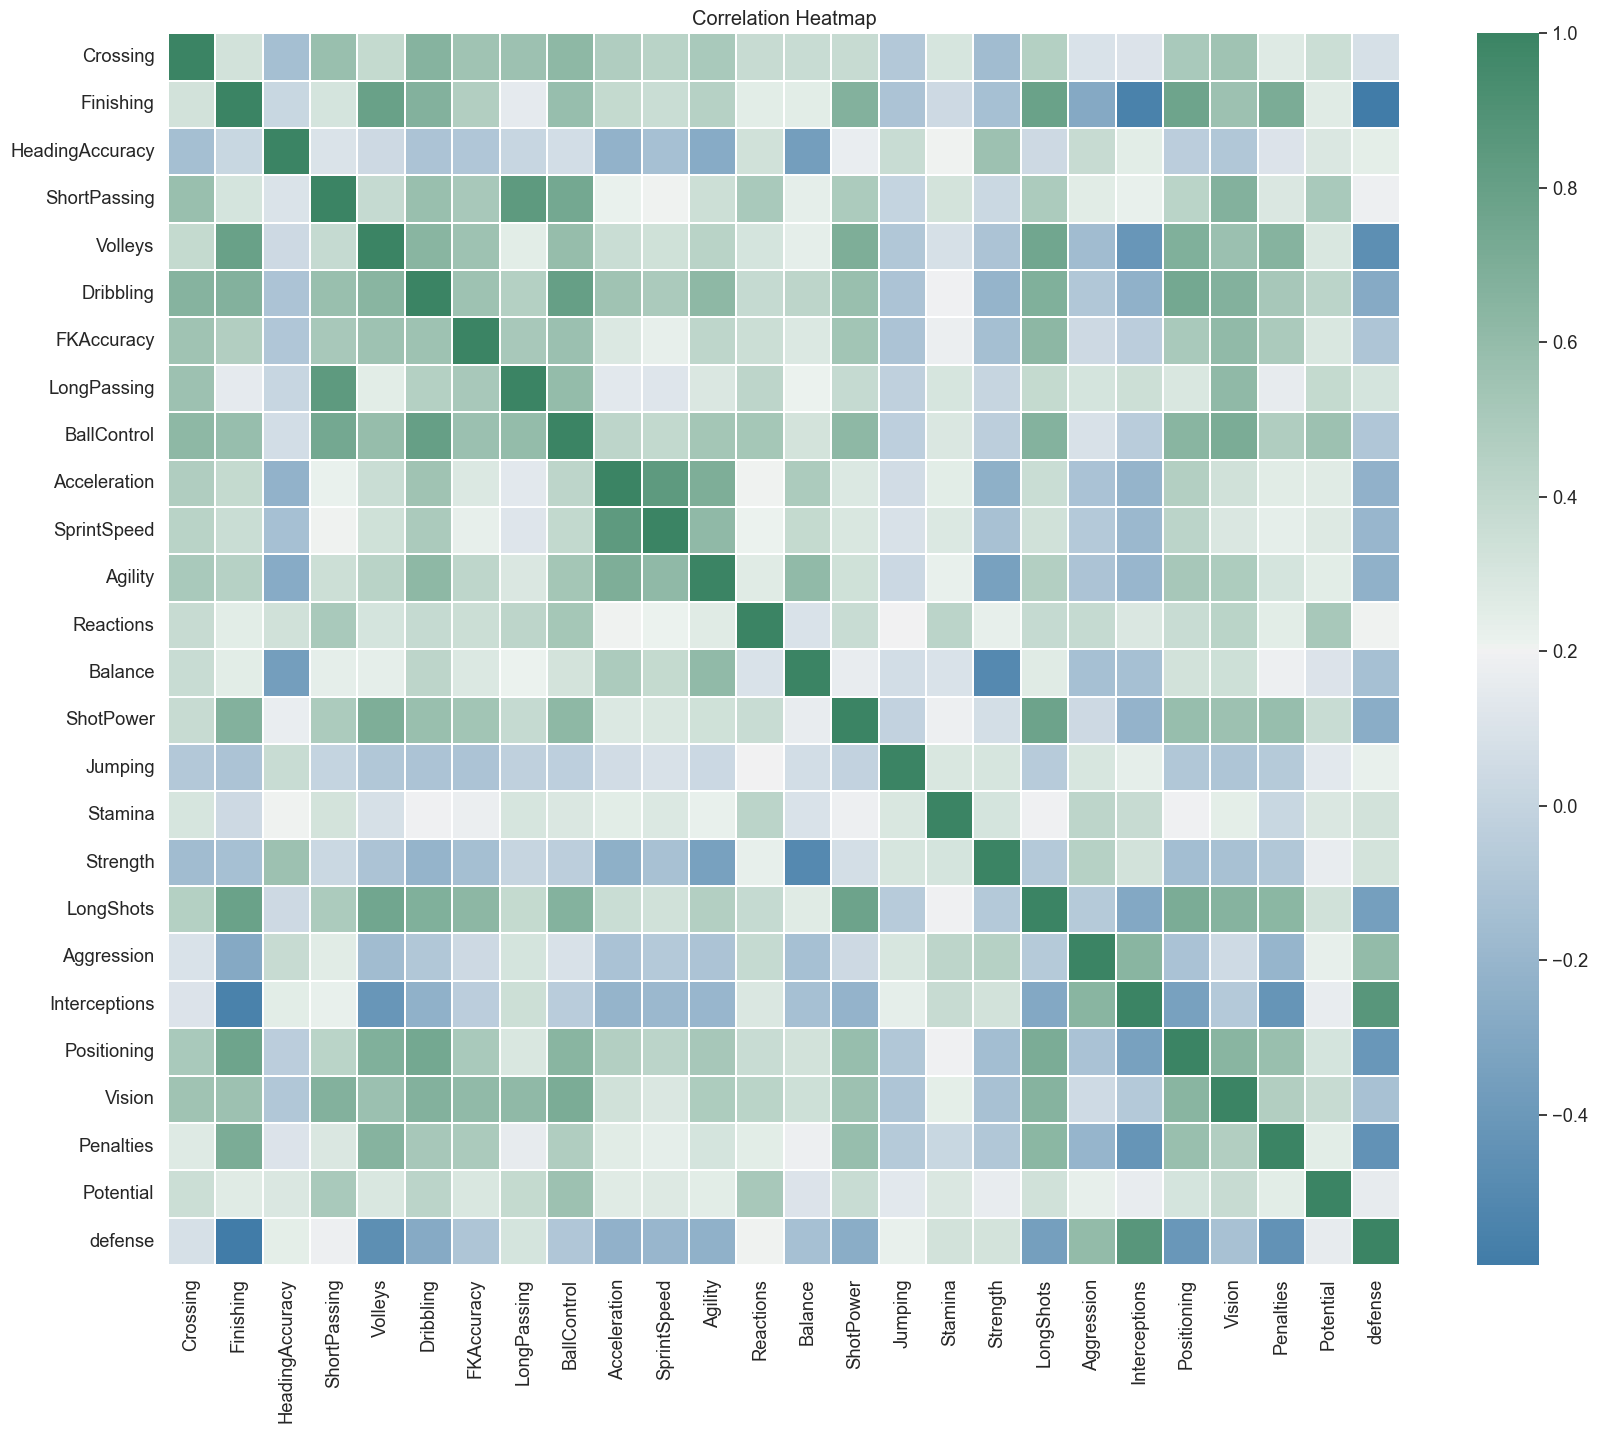

In [341]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Create a custom color map that smoothly transitions from dark green to gray
    cmap = sns.diverging_palette(600, 150, as_cmap=True)

    # Create a heatmap using Seaborn with the custom color map
    plt.figure(figsize=(20, 16))
    sns.set(font_scale=1.2)
    sns.heatmap(corr_matrix, cmap=cmap, annot=False, linewidths=0.1, square=True, cbar=True)

    # Set the plot title
    plt.title("Correlation Heatmap")

    # Show the plot
    plt.show()


# Example usage:
# Assuming you have a DataFrame named 'my_df'
plot_correlation_heatmap(df_processed)



In [342]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [344]:
df['target'].value_counts()

target
False    68709
True       183
Name: count, dtype: int64

In [345]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
import xgboost as xgb
import lightgbm as lgb
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

# Split the data into training and testing sets
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define class weights (if applicable)
class_weights = 'balanced'  # You can customize these weights if needed

# Create and train different classification models with class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight=class_weights),
    'Random Forest Classifier': RandomForestClassifier(class_weight=class_weights),
    'Support Vector Classifier': SVC(class_weight=class_weights,probability=True),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'LightGBM Classifier': lgb.LGBMClassifier()
}

model_results = {}

for model_name, model in models.items():
    print(model_name,"training----->")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    if y_prob is not None:
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    precision = precision_score(y_test, y_pred)
    
    model_results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix,
        'AUC': auc,
        'Precision': precision
    }

# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


Logistic Regression training----->
Decision Tree Classifier training----->
Random Forest Classifier training----->
Support Vector Classifier training----->
XGBoost Classifier training----->
LightGBM Classifier training----->
[LightGBM] [Info] Number of positive: 147, number of negative: 54966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1920
[LightGBM] [Info] Number of data points in the train set: 55113, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002667 -> initscore=-5.924038
[LightGBM] [Info] Start training from score -5.924038
Model: Logistic Regression
Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.67      0.80     13743
        True       0.00      0.53      0.01        36

    accuracy                           0.67     13779


In [354]:
my_model = model_results[ 'LightGBM Classifier']['Model']
y_test = pd.DataFrame(my_model.predict_proba(X_test)[:,1],columns=["prediction"],index=y_test.index)
y_test.sort_values(by="prediction",ascending = False).head(20)

,,,prediction
ID,Name,FIFA,
203376,V. van Dijk,2013,0.919163
201024,K. Koulibaly,2014,0.859117
192679,Escudero,2013,0.775475
207924,Lucas Lima,2017,0.746205
184267,Y. Brahimi,2013,0.727893
183766,B. Koné,2012,0.511579
238856,Pedro Sá,2018,0.494336
183129,C. Clark,2014,0.467395
200206,Alan Patrick,2011,0.419736


In [356]:
prospects = pd.DataFrame(my_model.predict_proba(df_potentials)[:,1],columns=["prediction"],index=df_potentials.index)

df_potentials.to_csv('potentials.csv')
prospects.sort_values(by="prediction",ascending = False).head(50)

,,,prediction
ID,Name,FIFA,
263295,M. Fall,2024,0.723568
267894,J. Solís,2024,0.275776
234575,Diogo Leite,2024,0.275396
241930,F. Gattoni,2024,0.136758
261195,E. Muçi,2024,0.082173
258446,M. Xantippe,2024,0.076154
267871,N. Fraser,2024,0.067802
262062,Metinho,2024,0.048062
267868,S. Braybrooke,2024,0.045047


['Crossing',
 'Finishing',
 'HeadingAccuracy',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Potential',
 'defense']

In [365]:
f_i = pd.DataFrame()
f_i["value"] = my_model.feature_importances_
f_i["feature"] = my_model.feature_name_
f_i['value'] = f_i['value']/f_i['value'].sum()

In [368]:
f_i.sort_values(ascending=False,by="value").to_csv('fi.csv')

In [370]:
plot_feature_importance(my_model, '')

AttributeError: 'LGBMClassifier' object has no attribute 'feature_names_in_'

In [ ]:
my_model.predict(df_potentials)

In [ ]:
my_model.feature_importances_

array([0.01691623, 0.01623886, 0.01259473, 0.00353655, 0.02073048,
       0.01202995, 0.00868168, 0.02457566, 0.00975131, 0.00184196,
       0.01076554, 0.02353866, 0.01223042, 0.03469861, 0.01383013,
       0.08472132, 0.        , 0.00667924, 0.0231404 , 0.01195785,
       0.02254167, 0.0221381 , 0.00777331, 0.02601108, 0.01339885,
       0.03949454, 0.00107363, 0.00407598, 0.01963827, 0.11048589,
       0.00532917, 0.00560381, 0.03226344, 0.0114282 , 0.02230002,
       0.28824703, 0.01973742])

In [ ]:
prospects.sort_values('prediction',ascending=False).round(3).head(50)

,,,prediction
ID,Name,FIFA,
201073,N. De Preville,2015,1.0
214651,C. Storie,2014,1.0
204485,R. Mahrez,2016,1.0
186962,F. Barillon,2011,1.0
238270,A. Erlingmark,2018,1.0
205700,A. Giļničs,2012,1.0
205586,I. Vassell,2012,1.0
201454,F. Ghoulam,2012,1.0
240806,E. Henderson,2019,1.0


In [ ]:
prospects.index.value_counts()

ID
199011    5
234889    5
203980    5
208160    4
208816    4
         ..
245059    1
203749    1
244958    1
189619    1
229905    1
Name: count, Length: 12927, dtype: int64

In [ ]:
pd.concat([df[['Name','Potential','prime']],prospects],axis=1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
pd.concat([y_test,model_results[ 'Logistic Regression Classifier']['Model'].predict_proba(X_test)[:,1]])

KeyError: 'Logistic Regression Classifier'

['Crossing',
 'Finishing',
 'HeadingAccuracy',
 'ShortPassing',
 'Volleys',
 'Dribbling',
 'FKAccuracy',
 'LongPassing',
 'BallControl',
 'Acceleration',
 'SprintSpeed',
 'Agility',
 'Reactions',
 'Balance',
 'ShotPower',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Potential',
 'defense']

In [383]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(model, title=None, top_n=10):
    # Extract feature importances from the model
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        raise ValueError("Model does not have feature importances.")

    if hasattr(model, 'feature_names_in_'):
        feature_names = model.feature_names_in_
    elif(model,'feature_name_'):
        feature_names = model.feature_name_
    else:
        raise ValueError("Model does not have feature names.")

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame()
    feature_importance_df["value"] = feature_importances/feature_importances.sum()
    feature_importance_df["names"] = feature_names
    feature_importance_df = feature_importance_df.sort_values(by="value", ascending=False)

    # Select the top N most important features
    top_features = feature_importance_df.iloc[:top_n, :]

    # Create a stylish horizontal bar plot with a black background and white fonts
    plt.figure(figsize=(10, 8), facecolor='black')
    colors = ['#808080', '#008080', '#6b8e23', '#F8766D', '#7CAE00', '#00BFC4', '#C77CFF', '#F564E3', '#FFB900', '#00D1FF']

    # Specify the font family (e.g., 'Arial', 'Times New Roman', 'Courier New', etc.)
    plt.rcParams['font.family'] = 'Times New Roman'

    plt.barh(top_features["names"], top_features["value"], color=colors[1])
    plt.xlabel('Feature Importance', fontsize=12, color='white')  # Set text color to white
    plt.ylabel('Features', fontsize=12, color='white')  # Set text color to white
    if title:
        plt.title(title, fontsize=16, fontweight='bold', color='white')  # Bold and bigger title
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis='x', linestyle='--', alpha=0.6, color='white')  # Add a white grid to the x-axis
    plt.gca().spines['top'].set_visible(False)  # Hide the top border
    plt.gca().spines['right'].set_visible(False)  # Hide the right border
    plt.gca().spines['bottom'].set_color('white')  # Set x-axis border color to white
    plt.gca().spines['left'].set_color('white')  # Set y-axis border color to white

    # Set color and fontweight of x-axis labels to white and bold
    plt.xticks(fontsize=10, fontweight='bold', color='white')

    # Set color of y-axis ticks to white
    plt.tick_params(axis='y', colors='white')

    plt.show()
    return list(top_features['names'].values)




In [384]:
rf_model = model_results['Random Forest Regressor']['Model']
# Example usage:
features = plot_feature_importance(decsion_tree, 'Feature Importance - Random Forest Regressor')

KeyError: 'Random Forest Regressor'

In [385]:
[i for i in models]

['Logistic Regression',
 'Decision Tree Classifier',
 'Random Forest Classifier',
 'Support Vector Classifier',
 'XGBoost Classifier',
 'LightGBM Classifier']

In [387]:
decsion_tree = model_results[ 'LightGBM Classifier']['Model']
# Example usage:
features = plot_feature_importance(decsion_tree, 'Feature Importance - Random Forest Regressor')